In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [2]:
import cv2
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, Dense, MaxPooling2D
from tensorflow.keras import Sequential

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.applications.resnet import preprocess_input
import tqdm 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Flatten)

from tensorflow.keras.layers import (Dense, Lambda, Dropout, Activation)
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

%matplotlib inline

# Functions

In [ ]:
def load_image_data(df,path="../Dataset/archive/image_data.npy"):
    """
        Parameters:
        1. df:
            Pandas dataframe        
        2. path: 
            The path to the image data npy file (numpy array file)
            Default: ../Dataset/archive/image_data.npy
        
        ------------------------
        Returns
            1. image_data: 
                Images in numpy array format of shape (n_samples,img_height,img_width,3)
            2. df
                Pandas dataframe with the non_included_ids removed
    """
    df_req = df.copy()
    non_included_ids = [39403, 39410, 39425]
    df_req = df_req[~df_req['id'].isin(non_included_ids)]
    from numpy import load
    image_data = load("../Dataset/archive/image_data.npy")
    return (image_data,df_req)
    
    
from tqdm import tqdm
import os
def load_image(imagePath):
    IMAGE_DIMS = (60,60,3)
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

def create_image_data(df,img_folder_path="../Dataset/archive/images/",should_save=False,save_path=None):
    """
        Creates numpy array of images
        
        Parameters:
            1. df
                Pandas dataframe containing image names
            2. img_folder_path
                The path of the folder to images.
                Default: '../Dataset/archive/images/'
            3. should
                Should the image array be saved as a file 
                Default: False
                Options: [True,False]
            4. save_path:
                The folder path to save the image_data                              
        
        Returns
            (non_included_ids,image_data)
            1. non_included_ids: 
                The image ids which could not be included
            2. image_data: 
                Images in numpy array format of shape (n_samples,img_height,img_width,3)        
    """
    from numpy import save
    
    
    
    df_req = df.copy()
    df_req['img_paths'] = df_req['id'].apply(lambda x:img_folder_path+str(x)+'.jpg')
    image_ids = df_req['img_paths']
    image_data = []
    non_included_ids = []

    for img_path,i in tqdm(zip(image_ids,df_req['id'])):

        try:
            image_data.append(load_image(img_path))
        except:
            non_included_ids.append(i)
            continue

    image_data = np.array(image_data, dtype="float")
    if should_save:
        save(save_path+"image_data.npy",image_data)
        print("Saved successfully to {}".format(save_path+"image_data.npy"))
    
def make_branch(res_input, n_out, act_type, name):
    """
        Parameters:
            1. res_input: 
                The input layer to the model
            2. n_out
                The number of output layers
            3. act_type
                Activation type
                Example: 'softmax','sigmoid','relu'
            4. name
                The name of the output layer
                
        Returns
            The output layer
    """
    z = Dense(512, activation="relu")(res_input)
    z = Dropout(0.3)(z)
    z = Dense(256, activation='relu')(z)
    z = Dense(128, activation='relu')(z)
#     z = BatchNormalization()(z)
#     z = Dropout(0.5)(z)
    z = Dense(n_out)(z)
    z = Activation(act_type, name=name+'_output')(z)
    return z

def get_split(df_req,image_data):
    """
        Parameters:
            1. df_req 
                Pandas dataframe
            2. image_data
                The numpy array of image_data
        Returns:
            Dictionary:
                1. d["LB"]: Label binarizers
                2. d["Splits"]: 
                    Tuple of the form 
                    (trainX, testX,
                     trainMasterCategoryY, testMasterCategoryY,
                     trainSubCategoryY, testSubCategoryY,
                     trainArticleTypeY, testArticleTypeY,
                     trainSeasonY, testSeasonY,
                     trainUsageY, testUsageY,
                     trainGenderY, testgenderY)

    """
    masterCategoryLB = LabelBinarizer()
    subCategoryLB = LabelBinarizer()
    articleTypeLB = LabelBinarizer()
    seasonLB = LabelBinarizer()
    usageLB = LabelBinarizer()
    genderLB = LabelBinarizer()

    masterCategoryLabels = masterCategoryLB.fit_transform(np.array(df_req['masterCategory'].values))
    subCategoryLabels = subCategoryLB.fit_transform(np.array(df_req['subCategory'].values))
    articleTypeLabels = articleTypeLB.fit_transform(np.array(df_req['articleType'].values))
    seasonLabels = seasonLB.fit_transform(np.array(df_req['season'].values))
    usageLabels = usageLB.fit_transform(np.array(df_req['usage'].values))
    genderLabels = genderLB.fit_transform(np.array(df_req['gender'].values))

    split = train_test_split(image_data,
                             masterCategoryLabels, 
                             subCategoryLabels, 
                             articleTypeLabels, 
                             seasonLabels, 
                             usageLabels,
                             genderLabels,
                             test_size=0.2, random_state=42)

    (trainX, testX,
     trainMasterCategoryY, testMasterCategoryY,
     trainSubCategoryY, testSubCategoryY,
     trainArticleTypeY, testArticleTypeY,
     trainSeasonY, testSeasonY,
     trainUsageY, testUsageY,
     trainGenderY, testgenderY) = split
    
    output = {}
    output["LB"] = {
        "masterCategoryLB": masterCategoryLB,
        "subCategoryLB": subCategoryLB,
        "articleTypeLB": articleTypeLB,
        "seasonLB": seasonLB,
        "usageLB": usageLB,
        "genderLB": genderLB
    }
    
    output["splits"] = (trainX, testX,
     trainMasterCategoryY, testMasterCategoryY,
     trainSubCategoryY, testSubCategoryY,
     trainArticleTypeY, testArticleTypeY,
     trainSeasonY, testSeasonY,
     trainUsageY, testUsageY,
     trainGenderY, testgenderY)
    
def build_model(width, height,data):
    """
    Parameters
        1. width: Image width
        2. height: Image height
        3. data: LB values
    
    """
    IMAGE_DIMS = (60,60,3)
    # -------------------------
    res50 = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_DIMS)
    res50.trainable=False
    inputs = Input(shape=IMAGE_DIMS)
    x = res50(inputs, training=False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    # -------------------------
    locals().update(data)
    masterCategory_branch = make_branch(x, len(masterCategoryLB.classes_), 'softmax', 'masterCategory')
    subCategory_branch = make_branch(x, len(subCategoryLB.classes_), 'softmax', 'subCategory')
    articleType_branch = make_branch(x, len(articleTypeLB.classes_), 'softmax', 'articleType')
    season_branch = make_branch(x, len(seasonLB.classes_), 'softmax', 'season')
    usage_branch = make_branch(x, len(usageLB.classes_), 'softmax', 'usage')
    gender_branch = make_branch(x, len(genderLB.classes_),'softmax','gender')

    model = Model(inputs=inputs,
                outputs=[masterCategory_branch, subCategory_branch, articleType_branch, 
                            season_branch, usage_branch,gender_branch])
    return model

# EDA

In [3]:
## Read styles dataset
df = pd.read_csv("../Dataset/archive/styles.csv",error_bad_lines=False)
df.head()

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [4]:
### Printing all columns of the dataset
all_columns = df.columns
numerical_columns = [x for x in df.columns if df[x].dtype in ["int64","float64"]]
categorical_columns = [x for x in df.columns if df[x].dtype in ["object"]]
print(all_columns)
print(numerical_columns)
print(categorical_columns)

print("\n\n")
print("All columns shape",df.shape[1])
print("Numerical columns shape",len(numerical_columns))
print("Categotical columns shape",len(categorical_columns))

Index(['id', 'gender', 'masterCategory', 'subCategory', 'articleType',
       'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
      dtype='object')
['id', 'year']
['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'usage', 'productDisplayName']



All columns shape 10
Numerical columns shape 2
Categotical columns shape 8


# Preprocessing

## 1. Handling Imbalance in dataset

In [5]:
## Gender
df['gender'].value_counts(ascending=False)
## Have to upsample images for unisex, boys, girls
## required columns = ['Men','Women','Unisex']

Men       22147
Women     18631
Unisex     2161
Boys        830
Girls       655
Name: gender, dtype: int64

In [6]:
## masterCategory
df['masterCategory'].value_counts(ascending=False)
## Can drop ['Free Items','Sporting Goods','Home']
## Have to upsample ['Accessories','Footwear','Personal Care']
## required columns = ['Accessories','Footwear','Personal Care','Apparel']

Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: masterCategory, dtype: int64

In [7]:
## sub category
df['subCategory'].value_counts(ascending=False)
## upsample ['Watches','Bottomwear','Bags','Shoes']
## required columns = ['Watches','Bottomwear','Bags','Shoes','Topwear']

Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Headwear                      293
Ties                          258
Accessories                   129
Scarves                       118
Cufflinks                     108
Apparel Set                   106
Free Gifts                    104
Stoles                         90
Skin Care                      77
Skin          

In [8]:
## article Type
df['articleType'].value_counts(ascending=False)
# required_fields = ['Tshirts','Shirts','Casual Shoes','Watches','Sports Shoes']
# upsample ['Shirts','Casual Shoes','Watches','Sports Shoes']

Tshirts                7067
Shirts                 3217
Casual Shoes           2845
Watches                2542
Sports Shoes           2036
                       ... 
Body Wash and Scrub       1
Ipad                      1
Mens Grooming Kit         1
Hair Accessory            1
Cushion Covers            1
Name: articleType, Length: 143, dtype: int64

In [9]:
## season
df['season'].value_counts(ascending=False)
# upsample ['Winter','Spring','Fall']
# required fields = ['Winter','Spring','Fall','Summer']

Summer    21472
Fall      11431
Winter     8517
Spring     2983
Name: season, dtype: int64

In [10]:
## Usage
df['usage'].value_counts(ascending=False)
# Upsample ['Sports','Ethnic','Formal']
# Required fields = ['Sports','Ethnic','Formal','Casual']

Casual          34406
Sports           4025
Ethnic           3208
Formal           2345
Smart Casual       67
Party              29
Travel             26
Home                1
Name: usage, dtype: int64

In [11]:
required_fields_dict = {
    "gender": ['Men','Women','Unisex'],
    "masterCategory": ['Accessories','Footwear','Personal Care','Apparel'],
    "subCategory": ['Watches','Bottomwear','Bags','Shoes','Topwear'],
    "articleType":['Tshirts','Shirts','Casual Shoes','Watches','Sports Shoes'],
    "season":['Winter','Spring','Fall','Summer'],
    "usage": ['Sports','Ethnic','Formal','Casual']
}

In [12]:
def remove_fields(df):
    df_copy = df.copy()
    for field in required_fields_dict.keys():
        df_copy = df_copy[df_copy[field].isin(required_fields_dict[field])]
    
    return df_copy

In [13]:
df_req = remove_fields(df)
print(df_req.shape)
df_req.head()

(16850, 10)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt


In [14]:
df_req['gender'].value_counts()

Men       13349
Women      3023
Unisex      478
Name: gender, dtype: int64

In [15]:
df_req.isnull().sum()

id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

# Finding feature dependance

In [16]:
corr_df = df_req.drop(['id','productDisplayName'],axis=1)
### Label Encoding
# categorical_fields = ['gender','masterCategory','subCategory','articleType','baseColour','season','year','usage']
# for field in categorical_fields:
#     corr_df[field],_ = pd.factorize(corr_df[field])
corr_df.head()

,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage
0,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual
2,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual
4,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual
5,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual
6,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic


In [17]:
X_features = corr_df.drop(['baseColour','usage','season'],axis=1)#[['masterCategory','articleType']]
y_season = corr_df['usage']

X_features_train,X_features_test,y_season_train, y_season_test = train_test_split(X_features,y_season,test_size=0.3,random_state=42)

In [18]:
print(X_features_train['masterCategory'].value_counts())
print(X_features_test['masterCategory'].value_counts())
print(y_season_train.value_counts())
print(y_season_test.value_counts())

Apparel        6656
Footwear       3377
Accessories    1762
Name: masterCategory, dtype: int64
Apparel        2887
Footwear       1436
Accessories     732
Name: masterCategory, dtype: int64
Casual    9049
Sports    2106
Formal     629
Ethnic      11
Name: usage, dtype: int64
Casual    3913
Sports     868
Formal     272
Ethnic       2
Name: usage, dtype: int64


In [19]:
X_features_train = pd.get_dummies(X_features_train,drop_first=True)
X_features_train.head()

,year,gender_Unisex,gender_Women,masterCategory_Apparel,masterCategory_Footwear,subCategory_Topwear,subCategory_Watches,articleType_Shirts,articleType_Sports Shoes,articleType_Tshirts,articleType_Watches
42650,2011.0,0,0,1,0,1,0,0,0,1,0
2184,2011.0,0,0,1,0,1,0,1,0,0,0
37399,2011.0,0,0,1,0,1,0,1,0,0,0
17958,2011.0,0,0,0,1,0,0,0,1,0,0
21484,2011.0,0,0,1,0,1,0,0,0,1,0


In [20]:
X_features_test = pd.get_dummies(X_features_test,drop_first=True)
X_features_test.head()

,year,gender_Unisex,gender_Women,masterCategory_Apparel,masterCategory_Footwear,subCategory_Topwear,subCategory_Watches,articleType_Shirts,articleType_Sports Shoes,articleType_Tshirts,articleType_Watches
29168,2011.0,0,0,1,0,1,0,0,0,1,0
12619,2011.0,0,0,0,1,0,0,0,1,0,0
42673,2011.0,0,0,1,0,1,0,0,0,1,0
11994,2011.0,0,0,0,1,0,0,0,1,0,0
38356,2011.0,0,0,1,0,1,0,0,0,1,0


In [21]:
# X_features_train.drop('year',axis=1,inplace=True)
# X_features_test.drop('year',axis=1,inplace=True)
print("Train: {}".format(X_features_train.shape))
print("Test: {}".format(X_features_test.shape))

Train: (11795, 11)
Test: (5055, 11)


<AxesSubplot:>

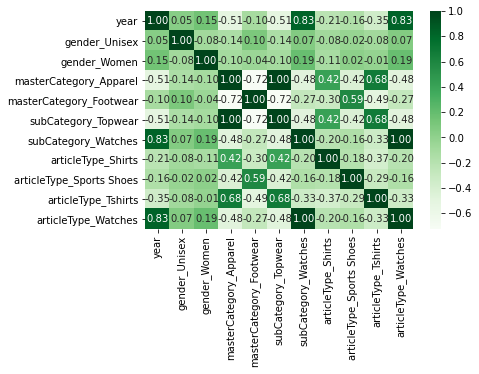

In [22]:
corr = X_features_train.corr()
sns.heatmap(corr,cmap="Greens",fmt=".2f",annot=True)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
clf = RandomForestClassifier()
clf.fit(X_features_train,y_season_train)
y_pred = clf.predict(X_features_test)
accuracy_score(y_season_test,y_pred)

0.8876360039564787

In [24]:
y_pred

array(['Casual', 'Sports', 'Casual', ..., 'Casual', 'Sports', 'Casual'],
      dtype=object)

<AxesSubplot:>

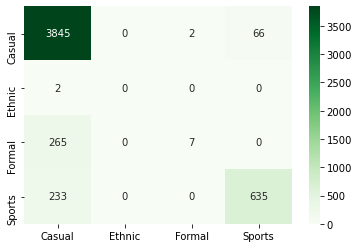

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_season_test,y_pred)
cm_df = pd.DataFrame(cm,columns=clf.classes_,index=clf.classes_)

sns.heatmap(cm_df,cmap="Greens",fmt="d",annot=True)

In [26]:
## Save Random forest model
## Inputs ['year','gender','masterCategory','subCategory','articleType','usage']

## 2. KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=12)
neigh.fit(X_features_train,y_season_train)

KNeighborsClassifier(n_neighbors=12)

In [28]:
neigh.classes_

array(['Casual', 'Ethnic', 'Formal', 'Sports'], dtype=object)

0.8880316518298714


<AxesSubplot:>

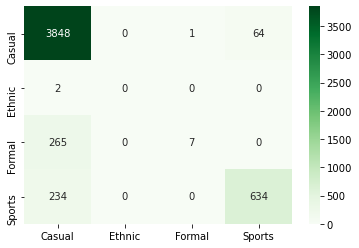

In [29]:
y_pred = neigh.predict(X_features_test)
print(accuracy_score(y_season_test,y_pred))
cm = confusion_matrix(y_season_test,y_pred)
cmdf = pd.DataFrame(cm,columns=neigh.classes_,index=neigh.classes_)
sns.heatmap(cmdf,cmap="Greens",annot=True,fmt="d")

### 2.2 Hyperparameter tuning

GridSearchCV is used to tune the hyperparameters

In [30]:
from sklearn.model_selection import GridSearchCV
KNeighborsClassifier()
grid_params = {
    'n_neighbors':[i for i in range(3,21,2)],
    'weights':['uniform','distance'],
    'metric':['euclidean','manhattan']
    
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=3,
    n_jobs=-1
)

gs_results = gs.fit(X_features_train,y_season_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


0.8878338278931751


<AxesSubplot:>

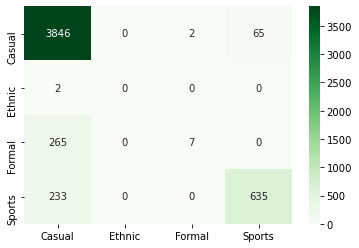

In [31]:
neigh = gs_results.best_estimator_
neigh.fit(X_features_train,y_season_train)
y_pred = neigh.predict(X_features_test)
print(accuracy_score(y_season_test,y_pred))
cmdf = pd.DataFrame(
    confusion_matrix(y_season_test,y_pred),
    index = neigh.classes_,
    columns = neigh.classes_
)

sns.heatmap(cmdf,annot=True,cmap="Greens",fmt="d")

## 3. Naive Bayes

0.8870425321463897


<AxesSubplot:>

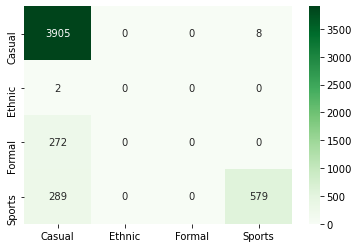

In [32]:
from sklearn.naive_bayes import GaussianNB,CategoricalNB,MultinomialNB
gnb = MultinomialNB()
gnb.fit(X_features_train,y_season_train)
y_pred = gnb.predict(X_features_test)

print(accuracy_score(y_season_test,y_pred))
cmdf = pd.DataFrame(
    confusion_matrix(y_season_test,y_pred),
    index = gnb.classes_,
    columns = gnb.classes_
)

sns.heatmap(cmdf,annot=True,cmap="Greens",fmt="d")

In [33]:
#Save model
#

## Deep learning model

In [34]:
#Output shape is 4
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_season_train = le.fit_transform(y_season_train)
y_season_train.shape

(11795,)

In [35]:
model = Sequential()
model.add(tf.keras.Input(shape=(8,)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dense(4,activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

In [36]:
model.fit(X_features_train,y_season_train,epochs=10)

Epoch 1/10


ValueError: in user code:

    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    E:\Downloads\AnacondaLatest\Anaconda\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:259 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 8 but received input with shape (None, 11)


In [ ]:
y_pred = model.predict(X_features_test)
y_pred = np.argmax(y_pred,axis=-1)

le = LabelEncoder()
y_test_labels = le.fit_transform(y_season_test)
accuracy_score(y_test_labels,y_pred)

In [ ]:
cm = confusion_matrix(y_test_labels,y_pred)
cm_df = pd.DataFrame(cm)
cm_df.columns = le.classes_
cm_df.index = le.classes_
sns.heatmap(cm_df,annot=True,fmt="d",cmap="Greens")

## 2. Class weights

In [ ]:
genderLB = LabelBinarizer()

In [ ]:
genderOHE = genderLB.fit_transform(df_req['gender'])
y_integers = np.argmax(genderOHE, axis=1)
class_weights = compute_class_weight('balanced', classes = np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))
d_class_weights

In [39]:
### Store image paths
img_folder_path = "../Dataset/archive/images/"
df_req['img_paths'] = df_req['id'].apply(lambda x:img_folder_path+str(x)+'.jpg')

In [40]:
IMAGE_DIMS = (60, 60, 3)
from tqdm import tqdm
import os
def load_image(imagePath):
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)
    return image

image_ids = df_req['img_paths']

image_data = []
non_included_ids = []

for img_path,i in tqdm(zip(image_ids,df_req['id'])):
    if not os.path.exists(img_path):
        non_included_ids.append(i)
    else:
        continue
#     try:
#         image_data.append(load_image(img_path))
#     except:
#         non_included_ids.append(i)
#         continue
    
# image_data = np.array(image_data, dtype="float")
# len(image_data)
non_included_ids

16850it [01:11, 235.22it/s] 


[39403, 39410, 39425]

In [41]:
non_included_ids = [39403, 39410, 39425]

In [31]:
# from numpy import save
# save("../Dataset/archive/image_data.npy",image_data)

# Individual models for each  tag

In [ ]:
def create_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(60, 60, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(3,activation='softmax'))

    model.summary()

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    
    return model

In [42]:
df_req = df_req[~df_req['id'].isin(non_included_ids)]

In [ ]:
genderOHE = genderLB.fit_transform(df_req['gender'])
y_integers = np.argmax(genderOHE, axis=1)
class_weights = compute_class_weight('balanced', classes = np.unique(y_integers), y=y_integers)
d_class_weights = dict(enumerate(class_weights))

In [ ]:
train_images = image_data[:14000]
test_images = image_data[14000:]

In [ ]:
train_labels = genderOHE[:14000]
test_labels = genderOHE[14000:]

In [ ]:
model = create_model()
history = model.fit(train_images, train_labels, epochs=10,validation_data=(test_images, test_labels),class_weight=d_class_weights)

In [ ]:
from sklearn.metrics import confusion_matrix
model1 = tf.keras.models.load_model("./gender_class_wghts_0.758_val.h5")
model2 = tf.keras.models.load_model("./gender_0.90_val.h5")
test_pred_ohe1 = model1.predict(test_images)
test_pred_integers1 = np.argmax(test_pred_ohe1,axis=1)

test_pred_ohe2 = model2.predict(test_images)
test_pred_integers2 = np.argmax(test_pred_ohe2,axis=1)

test_act_integers = np.argmax(test_labels,axis=1)
cm1 = confusion_matrix(y_true=test_act_integers,y_pred=test_pred_integers1)
cm2 = confusion_matrix(y_true=test_act_integers,y_pred=test_pred_integers2)

In [ ]:
genderCM1 = pd.DataFrame(cm1)
genderCM1.index = genderLB.classes_
genderCM1.columns = genderLB.classes_

sns.heatmap(genderCM1,annot=True,fmt="d",cmap="Greens")
plt.show()

genderCM2 = pd.DataFrame(cm2)
genderCM2.index = genderLB.classes_
genderCM2.columns = genderLB.classes_

sns.heatmap(genderCM2,annot=True,fmt="d",cmap="Greens")
plt.show()

# Branch based Model

In [43]:
from numpy import load
image_data = load("../Dataset/archive/image_data.npy")

In [44]:
def make_branch(res_input, n_out, act_type, name):
    z = Dense(512, activation="relu")(res_input)
    z = Dropout(0.3)(z)
    z = Dense(256, activation='relu')(z)
    z = Dense(128, activation='relu')(z)
#     z = BatchNormalization()(z)
#     z = Dropout(0.5)(z)
    z = Dense(n_out)(z)
    z = Activation(act_type, name=name+'_output')(z)
    return z

In [53]:
masterCategoryLB = LabelBinarizer()
subCategoryLB = LabelBinarizer()
articleTypeLB = LabelBinarizer()
seasonLB = LabelBinarizer()
usageLB = LabelBinarizer()
genderLB = LabelBinarizer()

masterCategoryLabels = masterCategoryLB.fit_transform(np.array(df_req['masterCategory'].values))
subCategoryLabels = subCategoryLB.fit_transform(np.array(df_req['subCategory'].values))
articleTypeLabels = articleTypeLB.fit_transform(np.array(df_req['articleType'].values))
seasonLabels = seasonLB.fit_transform(np.array(df_req['season'].values))
usageLabels = usageLB.fit_transform(np.array(df_req['usage'].values))
genderLabels = genderLB.fit_transform(np.array(df_req['gender'].values))

split = train_test_split(image_data,
                         masterCategoryLabels, 
                         subCategoryLabels, 
                         articleTypeLabels, 
                         seasonLabels, 
                         usageLabels,
                         genderLabels,
                         test_size=0.2, random_state=42)

(trainX, testX,
 trainMasterCategoryY, testMasterCategoryY,
 trainSubCategoryY, testSubCategoryY,
 trainArticleTypeY, testArticleTypeY,
 trainSeasonY, testSeasonY,
 trainUsageY, testUsageY,
 trainGenderY, testgenderY) = split

In [58]:
testGenderY

array([[0, 0, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [46]:
def build_model(width, height):

    # -------------------------
    res50 = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_DIMS)
    res50.trainable=False
    inputs = Input(shape=IMAGE_DIMS)
    x = res50(inputs, training=False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    # -------------------------

    masterCategory_branch = make_branch(x, len(masterCategoryLB.classes_), 'softmax', 'masterCategory')
    subCategory_branch = make_branch(x, len(subCategoryLB.classes_), 'softmax', 'subCategory')
    articleType_branch = make_branch(x, len(articleTypeLB.classes_), 'softmax', 'articleType')
    season_branch = make_branch(x, len(seasonLB.classes_), 'softmax', 'season')
    usage_branch = make_branch(x, len(usageLB.classes_), 'softmax', 'usage')
    gender_branch = make_branch(x, len(genderLB.classes_),'softmax','gender')

    model = Model(inputs=inputs,
                outputs=[masterCategory_branch, subCategory_branch, articleType_branch, 
                            season_branch, usage_branch,gender_branch])
    return model

In [59]:
model = build_model(60, 60)

losses = {
    "masterCategory_output": "categorical_crossentropy",
    "subCategory_output": "categorical_crossentropy",
    "articleType_output": "categorical_crossentropy",
    "season_output": "categorical_crossentropy",
    "usage_output": "categorical_crossentropy",
    "gender_output": "binary_crossentropy",
}

EPOCHS = 25
INIT_LR = 1e-5
BS = 32

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(optimizer=opt, loss=losses, metrics=["accuracy"])

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [60]:
H = model.fit(trainX,
    {"masterCategory_output": trainMasterCategoryY,
    "subCategory_output": trainSubCategoryY,
    "articleType_output": trainArticleTypeY,
    "season_output": trainSeasonY,
    "usage_output": trainUsageY,
     "gender_output": trainGenderY},
    validation_data=(testX, 
    {"masterCategory_output": testMasterCategoryY,
    "subCategory_output": testSubCategoryY,
    "articleType_output": testArticleTypeY,
    "season_output": testSeasonY,
    "usage_output": testUsageY,
     "gender_output": testGenderY}),
    epochs=10,
    batch_size=BS,
    verbose=1)


Epoch 1/10
422/422 [==============================] - 57s 77ms/step - loss: 4.5229 - masterCategory_output_loss: 0.3560 - subCategory_output_loss: 0.4905 - articleType_output_loss: 1.0190 - season_output_loss: 1.1527 - usage_output_loss: 0.9196 - gender_output_loss: 0.5851 - masterCategory_output_accuracy: 0.8582 - subCategory_output_accuracy: 0.8070 - articleType_output_accuracy: 0.6026 - season_output_accuracy: 0.4913 - usage_output_accuracy: 0.6992 - gender_output_accuracy: 0.6253 - val_loss: 1.8886 - val_masterCategory_output_loss: 0.0280 - val_subCategory_output_loss: 0.0314 - val_articleType_output_loss: 0.3195 - val_season_output_loss: 0.7832 - val_usage_output_loss: 0.4309 - val_gender_output_loss: 0.2956 - val_masterCategory_output_accuracy: 0.9938 - val_subCategory_output_accuracy: 0.9926 - val_articleType_output_accuracy: 0.8668 - val_season_output_accuracy: 0.6490 - val_usage_output_accuracy: 0.8332 - val_gender_output_accuracy: 0.8116 5.5658 - masterCategory_output_loss: 0

<AxesSubplot:>

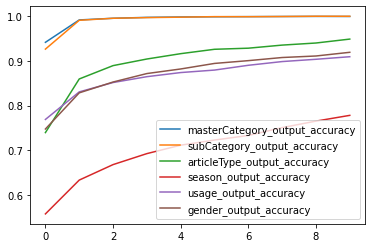

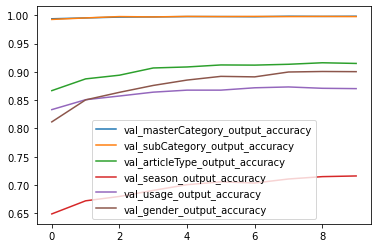

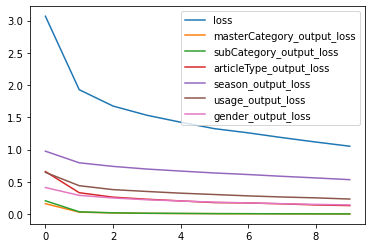

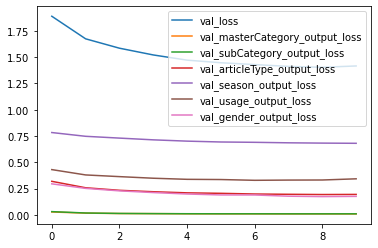

In [61]:
h_df = pd.DataFrame(H.history)
h_df.loc[:,[col for col in h_df.columns if 'accuracy' in col and 'val' not in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'accuracy' in col and 'val' in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'loss' in col and 'val' not in col]].plot()
h_df.loc[:,[col for col in h_df.columns if 'loss' in col and 'val' in col]].plot()

In [ ]:
res = model.evaluate(testX, 
    {"masterCategory_output": testMasterCategoryY,
    "subCategory_output": testSubCategoryY,
    "articleType_output": testArticleTypeY,
    "season_output": testSeasonY,
    "usage_output": testUsageY}, batch_size=32, verbose=0)
print('loss', res[:6])
print('acc', list(map(lambda x: round(x*100,2), res[6:])))

In [ ]:
model = tf.keras.models.load_model("../input/model-mul-v2/mulOut_v2.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Master Category: Footwear (100.00%) ----- Footwear
Sub Category: Shoes (100.00%) ----- Shoes
Article Type: Sports Shoes (55.74%) ----- Sports Shoes
Season: Summer (58.20%) ----- Summer
Usage: Sports (57.40%) ----- Sports
Gender: Men (100.00%) ----- Men


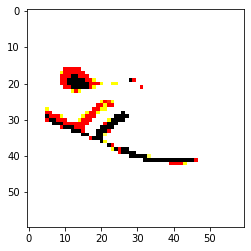

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).






Master Category: Footwear (100.00%) ----- Footwear
Sub Category: Shoes (100.00%) ----- Shoes
Article Type: Casual Shoes (95.65%) ----- Casual Shoes
Season: Summer (85.75%) ----- Fall
Usage: Casual (92.21%) ----- Casual
Gender: Men (98.72%) ----- Men


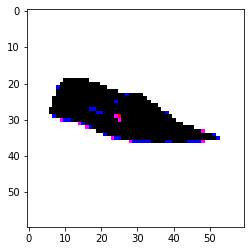





Master Category: Apparel (99.99%) ----- Apparel
Sub Category: Topwear (99.96%) ----- Topwear
Article Type: Tshirts (99.59%) ----- Tshirts


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Season: Fall (50.16%) ----- Fall
Usage: Casual (96.50%) ----- Casual
Gender: Men (94.60%) ----- Men


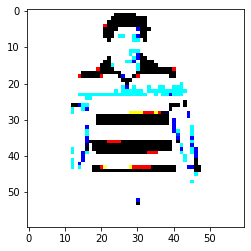





Master Category: Footwear (100.00%) ----- Footwear
Sub Category: Shoes (100.00%) ----- Shoes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Article Type: Casual Shoes (81.27%) ----- Sports Shoes
Season: Summer (79.19%) ----- Summer
Usage: Casual (66.86%) ----- Sports
Gender: Men (70.60%) ----- Women


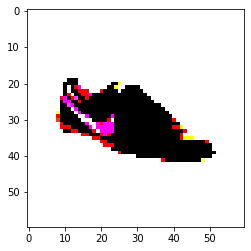

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Master Category: Apparel (100.00%) ----- Apparel
Sub Category: Topwear (100.00%) ----- Topwear
Article Type: Shirts (99.68%) ----- Shirts
Season: Fall (82.40%) ----- Fall
Usage: Formal (70.76%) ----- Casual
Gender: Men (100.00%) ----- Men


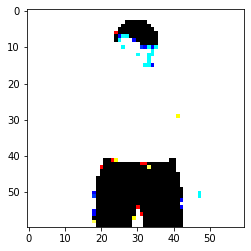

In [63]:
for idx in range(1,6):

    (masterCategoryProba, subCategoryProba, articleTypeProba, seasonProba, usageProba, genderProba) = model.predict(np.expand_dims(testX[idx], axis=0))

    masterCategoryIdx = masterCategoryProba[0].argmax()
    subCategoryIdx = subCategoryProba[0].argmax()
    articleTypeIdx = articleTypeProba[0].argmax()
    seasonIdx = seasonProba[0].argmax()
    usageIdx = usageProba[0].argmax()
    genderIdx = genderProba[0].argmax()
    masterCategoryLabel = masterCategoryLB.classes_[masterCategoryIdx]
    subCategoryLabel = subCategoryLB.classes_[subCategoryIdx]
    articleTypeLabel = articleTypeLB.classes_[articleTypeIdx]
    seasonLabel = seasonLB.classes_[seasonIdx]
    usageLabel = usageLB.classes_[usageIdx]
    genderLabel = genderLB.classes_[genderIdx]

    masterCategoryText = "Master Category: {} ({:.2f}%)".format(masterCategoryLabel, masterCategoryProba[0][masterCategoryIdx] * 100)
    subCategoryText = "Sub Category: {} ({:.2f}%)".format(subCategoryLabel, subCategoryProba[0][subCategoryIdx] * 100)
    articleTypeText = "Article Type: {} ({:.2f}%)".format(articleTypeLabel, articleTypeProba[0][articleTypeIdx] * 100)
    seasonText = "Season: {} ({:.2f}%)".format(seasonLabel, seasonProba[0][seasonIdx] * 100)
    usageText = "Usage: {} ({:.2f}%)".format(usageLabel, usageProba[0][usageIdx] * 100)
    genderText = "Gender: {} ({:.2f}%)".format(genderLabel, genderProba[0][genderIdx] * 100)

    print(masterCategoryText, '-----', masterCategoryLB.classes_[testMasterCategoryY[idx].argmax()])
    print(subCategoryText, '-----',subCategoryLB.classes_[testSubCategoryY[idx].argmax()])
    print(articleTypeText, '-----',articleTypeLB.classes_[testArticleTypeY[idx].argmax()])
    print(seasonText, '-----',seasonLB.classes_[testSeasonY[idx].argmax()])
    print(usageText, '-----',usageLB.classes_[testUsageY[idx].argmax()])
    print(genderText, '-----',genderLB.classes_[testGenderY[idx].argmax()])

    plt.imshow(testX[idx])
    plt.show()
    
    print("\n\n\n")

In [64]:
(masterCategoryProba, subCategoryProba, articleTypeProba, seasonProba, usageProba, genderProba) = model.predict(testX)

In [65]:
masterCategoryIntegers = np.argmax(masterCategoryProba,axis=-1)
subCategoryIntegers = np.argmax(subCategoryProba,axis=-1)
articleTypeIntegers = np.argmax(articleTypeProba,axis=-1)
seasonIntegers = np.argmax(seasonProba,axis=-1)
usageIntegers = np.argmax(usageProba,axis=-1)
genderIntegers = np.argmax(genderProba,axis=-1)

In [66]:
masterCategoryActual = np.argmax(testMasterCategoryY,axis=-1)
subCategoryActual = np.argmax(testSubCategoryY,axis=-1)
articleTypeActual = np.argmax(testArticleTypeY,axis=-1)
seasonActual = np.argmax(testSeasonY,axis=-1)
usageActual = np.argmax(testUsageY,axis=-1)
genderActual = np.argmax(testGenderY,axis=-1)

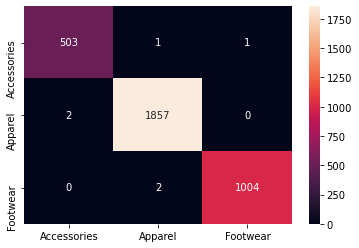

In [67]:
from sklearn.metrics import confusion_matrix,precision_score
masterCategoryCM = confusion_matrix(masterCategoryActual,masterCategoryIntegers)
masterCategoryCM_df = pd.DataFrame(masterCategoryCM)
masterCategoryCM_df.columns = masterCategoryLB.classes_
masterCategoryCM_df.index = masterCategoryLB.classes_
sns.heatmap(masterCategoryCM_df,annot=True,fmt="d")
plt.show()


<AxesSubplot:>

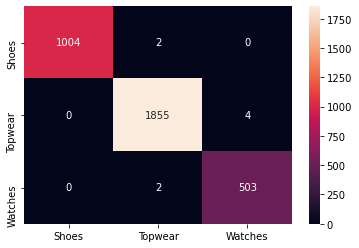

In [68]:
subCategoryCM = confusion_matrix(subCategoryActual,subCategoryIntegers)
subCategoryCM_df = pd.DataFrame(subCategoryCM)
subCategoryCM_df.columns = subCategoryLB.classes_
subCategoryCM_df.index = subCategoryLB.classes_
sns.heatmap(subCategoryCM_df,annot=True,fmt="d")

<AxesSubplot:>

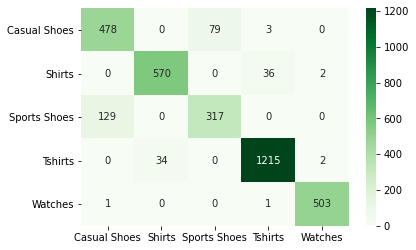

In [69]:
articleTypeCM = confusion_matrix(articleTypeActual,articleTypeIntegers)
articleTypeCM_df = pd.DataFrame(articleTypeCM)
articleTypeCM_df.columns = articleTypeLB.classes_
articleTypeCM_df.index = articleTypeLB.classes_
sns.heatmap(articleTypeCM_df,annot=True,fmt="d",cmap="Greens")

<AxesSubplot:>

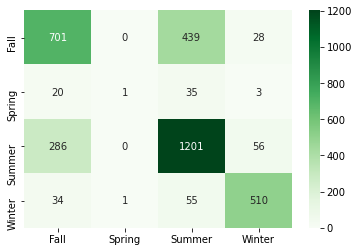

In [70]:
seasonCM = confusion_matrix(seasonActual,seasonIntegers)
seasonCM_df = pd.DataFrame(seasonCM)
seasonCM_df.columns = seasonLB.classes_
seasonCM_df.index = seasonLB.classes_
sns.heatmap(seasonCM_df,annot=True,fmt="d",cmap="Greens")

<AxesSubplot:>

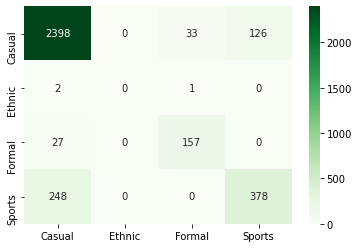

In [71]:
usageCM = confusion_matrix(usageActual,usageIntegers)
usageCM_df = pd.DataFrame(usageCM)
usageCM_df.columns = usageLB.classes_
usageCM_df.index = usageLB.classes_
sns.heatmap(usageCM_df,annot=True,fmt="d",cmap="Greens")

<AxesSubplot:>

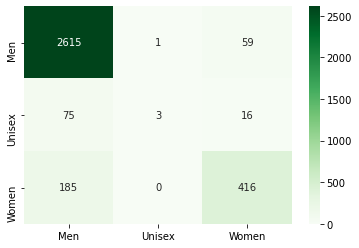

In [72]:
genderCM = confusion_matrix(genderActual,genderIntegers)
genderCM_df = pd.DataFrame(genderCM)
genderCM_df.columns = genderLB.classes_
genderCM_df.index = genderLB.classes_
sns.heatmap(genderCM_df,annot=True,fmt="d",cmap="Greens")

In [73]:
model.save('../models/mulOut_v3.h5')

In [ ]:
plot_model()

In [ ]:
plot_model(model)